# Оценка эффективности системы рекомендаций онлайн-магазина здорового питания

## Описание

В рамках задачи вам будет предложено поставить себя на место аналитика большого онлайн-магазина продуктов здорового питания.

У магазина есть приложение, внутри которого реализована рекомендательная система: она подсказывает пользователю, какие товары ему может быть интересно добавить в корзину. Раньше система была реализована довольно прямолинейно: пользователю предлагалось добавить те товары, которые он часто покупал в прошлом. Эту информацию можно получить из истории покупок пользователя.

Однако ваши коллеги из отдела разработки алгоритмов машинного обучения создали новую рекомендательную систему на основе нейронных сетей, которая с помощью данных о прошлых покупках пользователя и того, что покупают другие люди, предлагает ему релевантные товары. Важно, что система может рекомендовать не только то, что пользователь и так часто покупает, но и абсолютно новые продукты, которые он раньше никогда не пробовал.

Возникает вопрос: действительно ли новый алгоритм работает лучше, чем существующий?

Чтобы ответить на него, вы с коллегами провели A/B-эксперимент, в ходе которого контрольная группа пользователей продолжала пользоваться старой версией системы рекомендаций, а экспериментальная группа использовала новый алгоритм. Период проведения эксперимента — с 01.10.2023 по 14.10.2023 включительно.

Задача

Ваша задача состоит в том, чтобы проанализировать собранные в ходе эксперимента данные и определить, станет ли лучше от использования нового алгоритма рекомендаций.

**Таблица «user»**

В таблице содержится общая информация о пользователях онлайн-магазина.

Таблица содержит следующие колонки:

«id» — уникальный идентификатор пользователя.

«gender» — пол пользователя. Значение «М» соответствует мужскому полу, значение «Ж» — женскому.

«age» — возраст пользователя на момент 01.09.2023.

«region» — регион, в котором проживает пользователь.


**Таблица «user_ab_group»**

В таблице содержится информация о том, в какую группу в рамках эксперимента входил тот или иной пользователь. Важно, что в эксперименте участвовали не все пользователи. Поэтому некоторых из них нет в данной таблице.

Таблица содержит следующие колонки:

«user_id» — идентификатор пользователя.

«group» — название группы, в которую входил пользователь в рамках эксперимента. Название «control» соответствует контрольной группе, а «treatment» — экспериментальной.


**Таблица «good»**

В таблице содержится общая информация о продуктах, которые можно купить в магазине.

Таблица содержит следующие колонки:

«id» — уникальный идентификатор товара.

«good_name» — название товара.

«price_per_unit» — цена за одну условную единицу товара.


**Таблица «user_purchase»**

В таблице содержится информация о покупках, которые совершали пользователи. Важно, что в таблице присутствуют данные и о том, как эти же самые пользователи совершали покупки вне периода проведения эксперимента.

Таблица содержит следующие колонки:

«id» — уникальный идентификатор покупки.

«user_id» — идентификатор пользователя, который совершил эту покупку.

«date_time» — момент времени, когда была совершена покупка. Формат представления момента времени: %Y-%m-%d %H:%M:%S.


**Таблица «purchase_good»**

В таблице содержится информация о товарах, которые входили в список покупок, совершённых пользователями. Каждому товару из конкретной покупки соответствует отдельная строчка в таблице.

Таблица содержит следующие колонки:

«purchase_id» — идентификатор покупки.

«good_id» — идентификатор товара, который входит в эту покупку.

«amount» — количество единиц товара, входящих в покупку. Для простоты будем считать, что это всегда целочисленное значение.

«was_in_recommended_goods» — значение, которое показывает, был ли приобретённый продукт добавлен в корзину по рекомендации: True — если был, False — если нет.

In [1]:
import pandas as pd
import seaborn as sns
import random
from scipy import stats

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Постановка гипотез

H0 - доходы магазина от покупок по рекомендациям контрольной и экспериментальной групп отличаются несущественно

H1 - гипотеза H0 неверна

Метрика: на сколько процентов выше доход магазина от экспериментальной группы по сравнению с доходом от контрольной группы

## Предобработка данных

In [3]:
user = pd.read_csv('user.csv')
user_ab = pd.read_csv('user_ab_group.csv')
good = pd.read_csv('good.csv')
user_purchase = pd.read_csv('user_purchase.csv')
purchase_good = pd.read_csv('purchase_good.csv')

In [4]:
user.head()

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область


In [5]:
user.info(), user.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  15000 non-null  int64 
 1   gender   15000 non-null  object
 2   age      15000 non-null  int64 
 3   region   15000 non-null  object
dtypes: int64(2), object(2)
memory usage: 468.9+ KB


(None,
 user_id    15000
 gender         2
 age           38
 region         7
 dtype: int64)

In [6]:
user.age.min(), user.age.max()

(np.int64(14), np.int64(58))

In [7]:
user_ab.head()

,user_id,group
0,5034,treatment
1,4725,treatment
2,911,treatment
3,13267,control
4,5636,control


In [8]:
user_ab.info(), user_ab.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11915 entries, 0 to 11914
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  11915 non-null  int64 
 1   group    11915 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.3+ KB


(None,
 user_id    11915
 group          2
 dtype: int64)

In [9]:
user_ab[user_ab['group'] == 'control'].count() / user_ab[user_ab['group'] == 'treatment'].count()

user_id    0.989149
group      0.989149
dtype: float64

In [10]:
good.head()

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480


In [11]:
good.info(), good.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              100 non-null    int64 
 1   good_name       100 non-null    object
 2   price_per_unit  100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


(None,
 id                100
 good_name         100
 price_per_unit     87
 dtype: int64)

In [12]:
good.price_per_unit.min(), good.price_per_unit.max()

(np.int64(299), np.int64(796))

In [13]:
user_purchase.head()

,id,user_id,date_time
0,1,5784,2023-09-20 00:01:07
1,2,4468,2023-09-20 00:04:18
2,3,3827,2023-09-20 00:04:35
3,4,3272,2023-09-20 00:06:32
4,5,9461,2023-09-20 00:08:24


In [14]:
user_purchase.dtypes

id            int64
user_id       int64
date_time    object
dtype: object

In [15]:
user_purchase['date_time'] = pd.to_datetime(user_purchase['date_time'], format = '%Y-%m-%d %H:%M:%S')

In [16]:
user_purchase.head(), user_purchase.dtypes

(   id  user_id           date_time
 0   1     5784 2023-09-20 00:01:07
 1   2     4468 2023-09-20 00:04:18
 2   3     3827 2023-09-20 00:04:35
 3   4     3272 2023-09-20 00:06:32
 4   5     9461 2023-09-20 00:08:24,
 id                    int64
 user_id               int64
 date_time    datetime64[ns]
 dtype: object)

In [17]:
user_purchase['date_time'].min(), user_purchase['date_time'].max()

(Timestamp('2023-09-20 00:01:07'), Timestamp('2023-11-28 23:57:51'))

Эксперимент был с 1 по 14 открября включительно, поэтому убираем лишние покупки из списка

In [18]:
user_purchase = user_purchase[(user_purchase['date_time'] >= pd.Timestamp('2023-10-01 00:00:00')) & (user_purchase['date_time'] < pd.Timestamp('2023-10-15 00:00:00'))]

In [19]:
user_purchase['date_time'].min(), user_purchase['date_time'].max()

(Timestamp('2023-10-01 00:02:06'), Timestamp('2023-10-14 23:58:28'))

In [20]:
purchase_good = pd.read_csv('purchase_good.csv')

In [21]:
purchase_good.head()

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True


В задаче требуется проанализировать систему рекомендаций, поэтому отсеим was_in_recommended_goods = True. Также отсеим покупки, сделанные во время проведения эксперимента

In [22]:
purchase_good.info(), purchase_good.nunique(), purchase_good.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352057 entries, 0 to 352056
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   purchase_id               352057 non-null  int64
 1   good_id                   352057 non-null  int64
 2   amount                    352057 non-null  int64
 3   was_in_recommended_goods  352057 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 8.4 MB


(None,
 purchase_id                 74951
 good_id                       100
 amount                          5
 was_in_recommended_goods        2
 dtype: int64,
 purchase_id                 int64
 good_id                     int64
 amount                      int64
 was_in_recommended_goods     bool
 dtype: object)

In [23]:
purchase_good = purchase_good[(purchase_good['was_in_recommended_goods'] == True) & (purchase_good['purchase_id'].isin(user_purchase['id']))].drop(columns = 'was_in_recommended_goods')

In [24]:
purchase_good.info(), purchase_good.nunique(), purchase_good.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 31963 entries, 11 to 352032
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   purchase_id  31963 non-null  int64
 1   good_id      31963 non-null  int64
 2   amount       31963 non-null  int64
dtypes: int64(3)
memory usage: 998.8 KB


(None,
 purchase_id    11014
 good_id          100
 amount             4
 dtype: int64,
 purchase_id    int64
 good_id        int64
 amount         int64
 dtype: object)

## Обработка данных

Посчитаем суммарные доходы от покупок по рекомендациям у контрольной и тестовой групп

In [25]:
purchase = purchase_good.merge(user_purchase, left_on = 'purchase_id', right_on = 'id', how = 'left')

In [26]:
purchase.head()

,purchase_id,good_id,amount,id,user_id,date_time
0,20107,6,1,20107,2,2023-10-08 19:23:44
1,20107,36,1,20107,2,2023-10-08 19:23:44
2,20107,10,2,20107,2,2023-10-08 19:23:44
3,20107,29,1,20107,2,2023-10-08 19:23:44
4,20107,27,1,20107,2,2023-10-08 19:23:44


In [27]:
purchase = purchase[['id', 'good_id', 'amount', 'user_id']]

In [28]:
purchase.head()

,id,good_id,amount,user_id
0,20107,6,1,2
1,20107,36,1,2
2,20107,10,2,2
3,20107,29,1,2
4,20107,27,1,2


In [29]:
purchase = purchase.merge(good, left_on = 'good_id', right_on = 'id', how = 'left')

In [30]:
purchase.head()

,id_x,good_id,amount,user_id,id_y,good_name,price_per_unit
0,20107,6,1,2,6,Греческий йогурт с низким содержанием жира,426
1,20107,36,1,2,36,Льняные хлопья,404
2,20107,10,2,2,10,Мед манука,497
3,20107,29,1,2,29,Кокосовая вода,432
4,20107,27,1,2,27,Ягоды годжи,587


In [31]:
purchase = purchase[['id_x', 'price_per_unit', 'amount', 'user_id']].copy()

In [32]:
purchase['profit'] = purchase['price_per_unit'] * purchase['amount']

In [34]:
purchase = purchase.rename(columns = {'id_x': 'id'})

In [35]:
purchase.head(3)

,id,price_per_unit,amount,user_id,profit
0,20107,426,1,2,426
1,20107,404,1,2,404
2,20107,497,2,2,994


In [36]:
purchase = purchase.merge(user_ab, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [37]:
purchase.head()

,id,price_per_unit,amount,user_id,profit,group
0,20107,426,1,2,426,treatment
1,20107,404,1,2,404,treatment
2,20107,497,2,2,994,treatment
3,20107,432,1,2,432,treatment
4,20107,587,1,2,587,treatment


In [38]:
purchase[purchase['group'] == 'control']['user_id'].nunique(), purchase[purchase['group'] == 'treatment']['user_id'].nunique()

(3132, 3916)

Заметим, что размер выборок разный, поэтому вторая группа могла принести больше прибыли из-за количества людей, а не из-за новой системы

In [39]:
purchase['profit'].min(), purchase['profit'].max()

(np.int64(299), np.int64(3184))

In [40]:
purchase.groupby('group', as_index = False).agg({'profit': 'sum'})

,group,profit
0,control,4738958
1,treatment,11855115


In [41]:
round((11855115 - 4738958) / 4738958 * 100)

150

Если рассмотреть доходы магазина со всех пользователей из каждой группы, то перевес в сторону новой системы очевиден (доход с экспериментальной группы на 150% выше)

Рассмотрим равные по объёму выборки из данных совокупностей

In [42]:
random_number_gen = random.Random()

In [43]:
group_c = []
group_t = []
differences = []
id_c_l = purchase[purchase['group'] == 'control']['id'].to_list()
id_t_l = purchase[purchase['group'] == 'treatment']['id'].to_list()

for _ in range(1000):
    profit_c = purchase[purchase['id'].isin(random_number_gen.sample(id_c_l, 400))]['profit'].sum()
    profit_t = purchase[purchase['id'].isin(random_number_gen.sample(id_t_l, 400))]['profit'].sum()

    group_c += [profit_c]
    group_t += [profit_t]
    differences += [(profit_t - profit_c) / profit_c * 100]

In [44]:
len(differences)

1000

<Axes: ylabel='Count'>

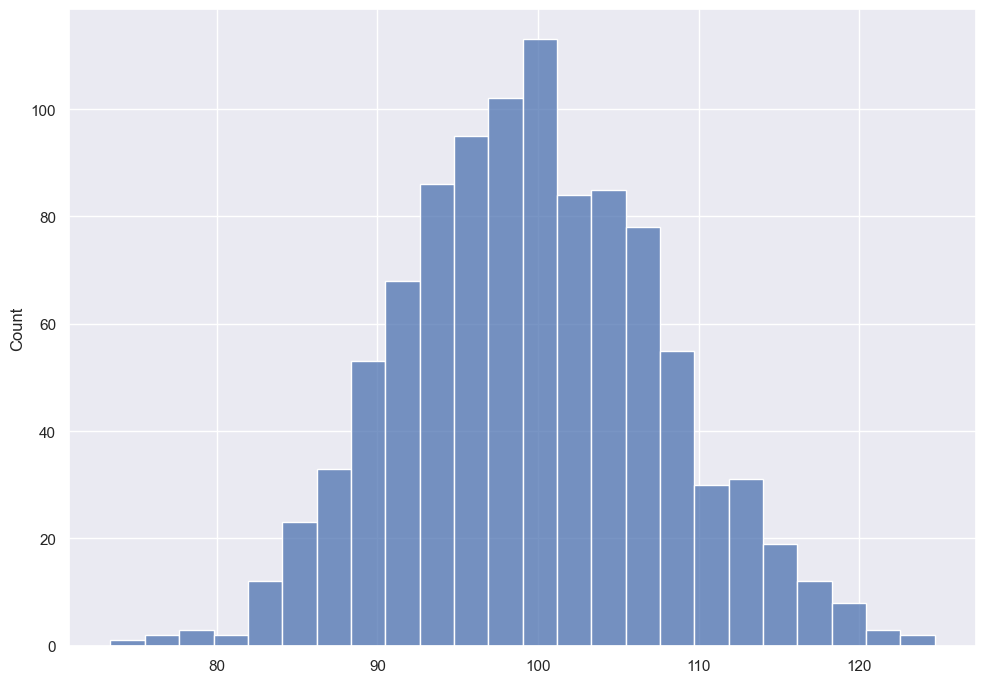

In [45]:
sns.histplot(differences)

In [46]:
pd.Series(differences).mean()

np.float64(99.5860709406338)

## Вывод

Новая рекомендательная система в среднем показывает на 99% больший доход для магазина, по сравнению со старой. Гипотезу H0 отвергаем

## Дополнительное исследование

Проверяем гипотезу о равенстве дисперсий в группах

In [47]:
stat, p = stats.levene(group_c, group_t)

In [48]:
stat, p

(np.float64(358.95886635880174), np.float64(9.424935497280903e-74))

Видим, что p близко к нулю, значит отвергаем гипотезу о том, что дисперсии групп равны. В таком случае использует t-тест Уэлча

In [49]:
t_stat, p_value = stats.ttest_ind(group_c, group_t, equal_var=True)

In [50]:
t_stat, p_value

(np.float64(-500.88080339495923), np.float64(0.0))

Получено значение p_value = 0.0, значит в среднем выборки не показывают равенства доходов для магазина, а следовательно нулевую гипотезу H0 отвергаем